In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as pl

# Diät Problem

In [2]:
%%HTML

<table border="1"><tr><td><b>Food</b></td><td><b>Cost per serving</b></td><td><b>Vitamin A</b></td><td><b>Calories</b></td></tr><tr><td>Corn</td><td>$0.18</td><td>107</td><td>72</td></tr><tr><td>2% Milk</td><td>$0.23</td><td>500</td><td>121</td></tr><tr><td>Wheat Bread</td><td>$0.05</td><td>0</td><td>65</td></tr></table>
<a href="http://www.neos-guide.org/content/diet-problem#formulation">Source</a>

Food,Cost per serving,Vitamin A,Calories
Corn,$0.18,107,72
2% Milk,$0.23,500,121
Wheat Bread,$0.05,0,65


In [3]:
COST = np.array([0.18, 0.23, 0.05])
VITAMIN = np.array([107, 500, 0])
CALORIES = np.array([72, 121, 65])

servings = cvx.Variable(3)
objective = cvx.Minimize(COST * servings)
constraints = []
problem = cvx.Problem(objective, constraints)
problem.solve()
print(problem.status)
print(servings.value)

unbounded
None


# Least Square Fit

Approximiere Datenpunkte $(x_i, y_i)$ durch lineare Funktion $f(x) = mx + n$ $\implies$ Least Square Fit
$$\mathrm{min}\, \sum_i (m x_i + n - y_i)^2$$

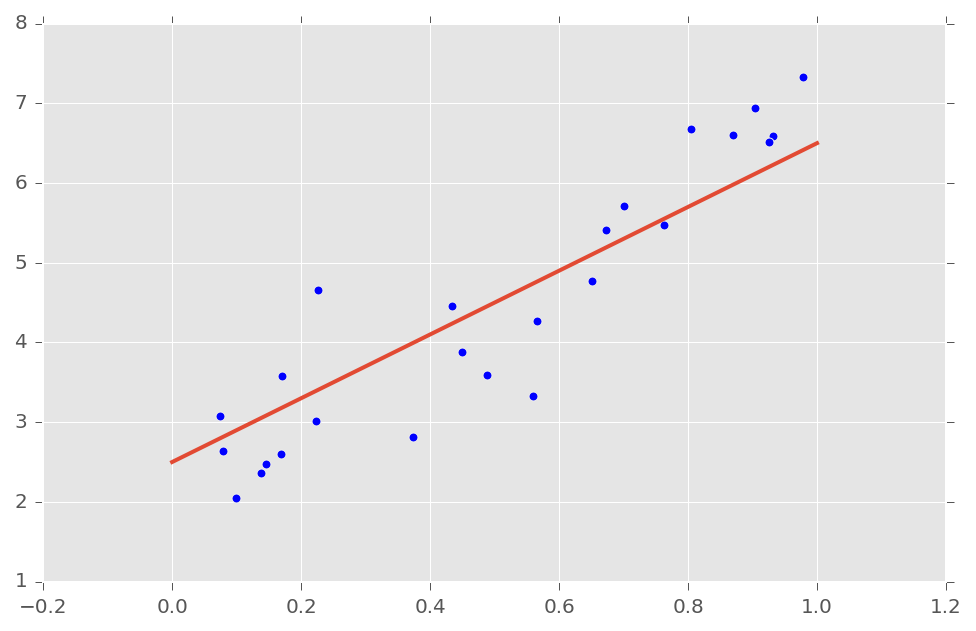

In [4]:
m, n, sigma = 4, 2.5, .5
samples = 25
xs = rd.uniform(size=samples)
ys = m * xs + n + sigma * rd.randn(len(xs))
pl.scatter(xs, ys)

x = np.linspace(0, 1, 10)
pl.plot(x, m * x + n)

In [7]:
m_sharp = cvx.Variable()
n_sharp = cvx.Variable()
objective = cvx.Minimize(cvx.norm2(m_sharp * xs + n_sharp - ys))
problem = cvx.Problem(objective, [])
problem.solve()
print("Status: {}".format(problem.status))

Status: optimal


m_sharp=4.9705871617411015, n_sharp=1.9693953845439607


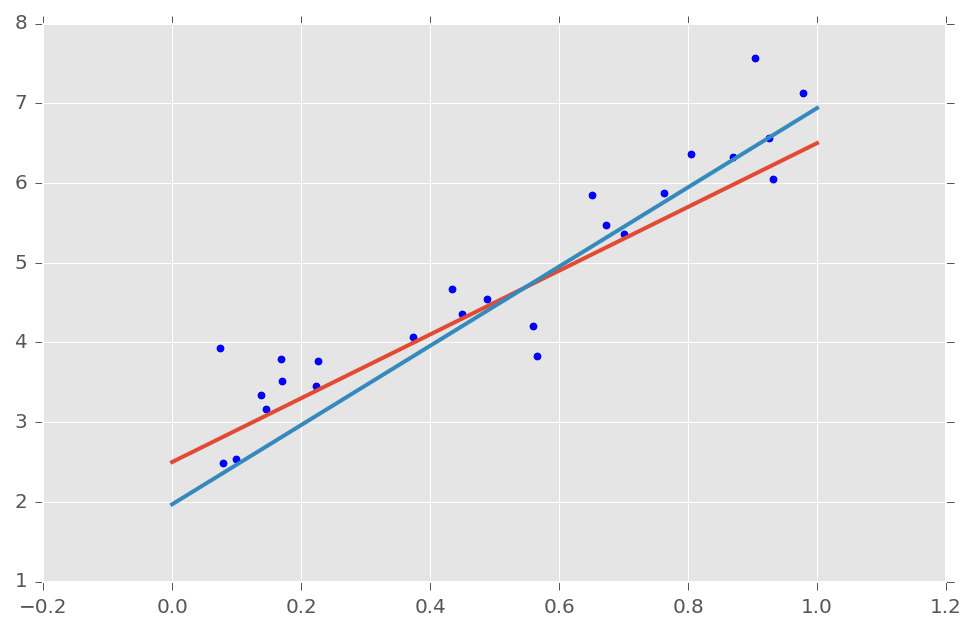

In [8]:
ms, ns = m_sharp.value, n_sharp.value

ys = m * xs + n + sigma * rd.randn(len(xs))
pl.scatter(xs, ys)

pl.plot(x, m * x + n, label="Reference")
pl.plot(x, ms * x + ns, label="Reconstruction")

print("m_sharp={}, n_sharp={}".format(ms, ns))

# Compressed Sensing

In [9]:
import sys
sys.path.append('/Users/dsuess/Code/2dspectra/')
import routines as rt

NONZERO_FREQUENCIES = 10
N = 512
A = np.zeros(2*N - 1)

k = rd.randint(2*N - 1, size=NONZERO_FREQUENCIES)
A[k] += rd.uniform(-1, 1, NONZERO_FREQUENCIES)
omega = np.arange(N)
measurements = rt.sensing_matrix(N)
signal = measurements.dot(A)

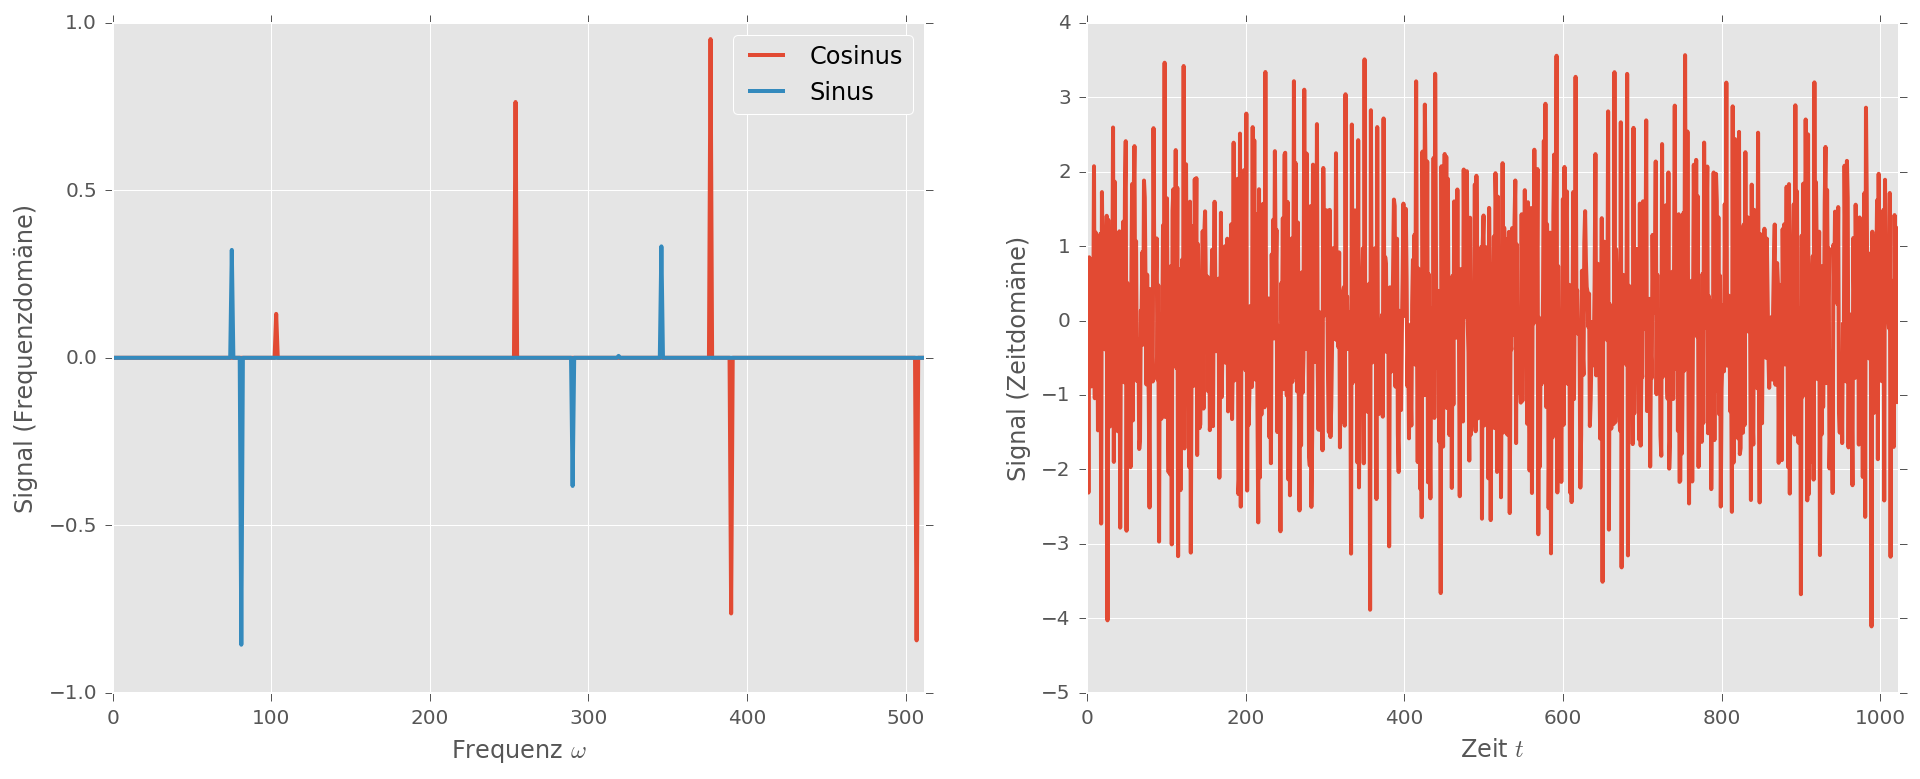

In [10]:
pl.figure(0, figsize=(16, 6))
pl.subplot(121)
pl.plot(omega, A[:N], label='Cosinus')
pl.plot(omega[1:], A[N:], label='Sinus')
pl.xlim(0, N)
pl.xlabel(r"Frequenz $\omega$")
pl.ylabel(u"Signal (Frequenzdomäne)")
pl.legend()

pl.subplot(122)
pl.plot(signal)
pl.xlabel(r"Zeit $t$")
pl.ylabel(u"Signal (Zeitdomäne)")
pl.xlim(0, 2*N - 1)
pl.show()

$$F(\Delta t \, n) = A_0 + \sum_{k=1}^{N-1} (A_k \cos (\Delta\Omega \, k n) + B_k \sin (\Delta\Omega \, k n)) \quad (n=0,\ldots,2N - 1)$$

In [11]:
def constraint_basis_pursuit(FT, y):
    """ min_z |z|_1   s.t.   FT . z == y

    FT -- sensing matrix
    y -- measurement results
    """
    z = cvx.Variable(FT.shape[1])
    obj = cvx.Minimize(cvx.norm1(z))
    cons = [FT * z == y]
    prob = cvx.Problem(obj, cons)
    prob.solve()

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise RuntimeError("Optimization did not converge: " + prob.status)
    return np.array(z.value)[:, 0]

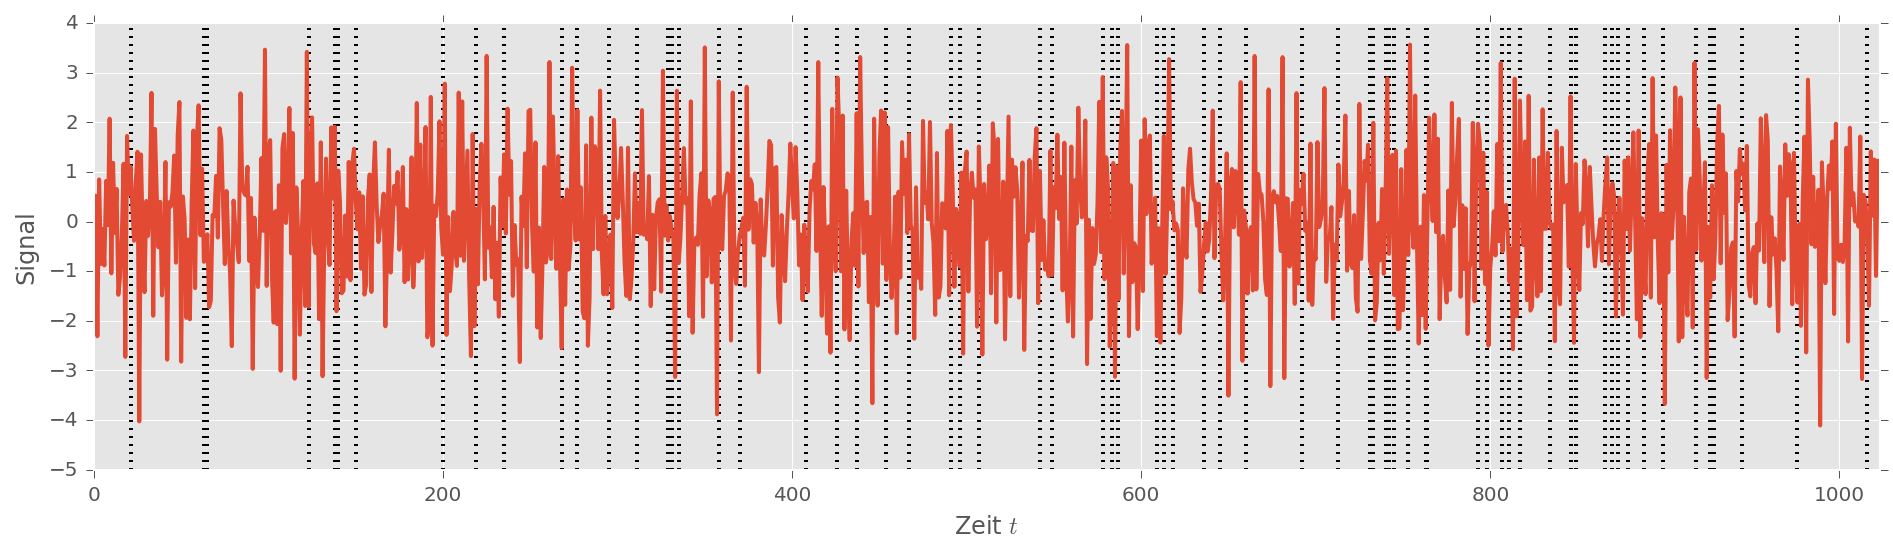

In [12]:
sample_points = rd.randint(low=0, high=len(signal), size=70)

pl.figure(0, figsize=(16, 4))
ax = pl.gca()
ax.plot(signal)
ax.set_xlabel(r"Zeit $t$")
ax.set_ylabel(r"Signal")
ax.set_xlim(0, 2*N - 1)
pl.vlines(sample_points, *ax.get_ylim(), linestyles=':')
pl.show()

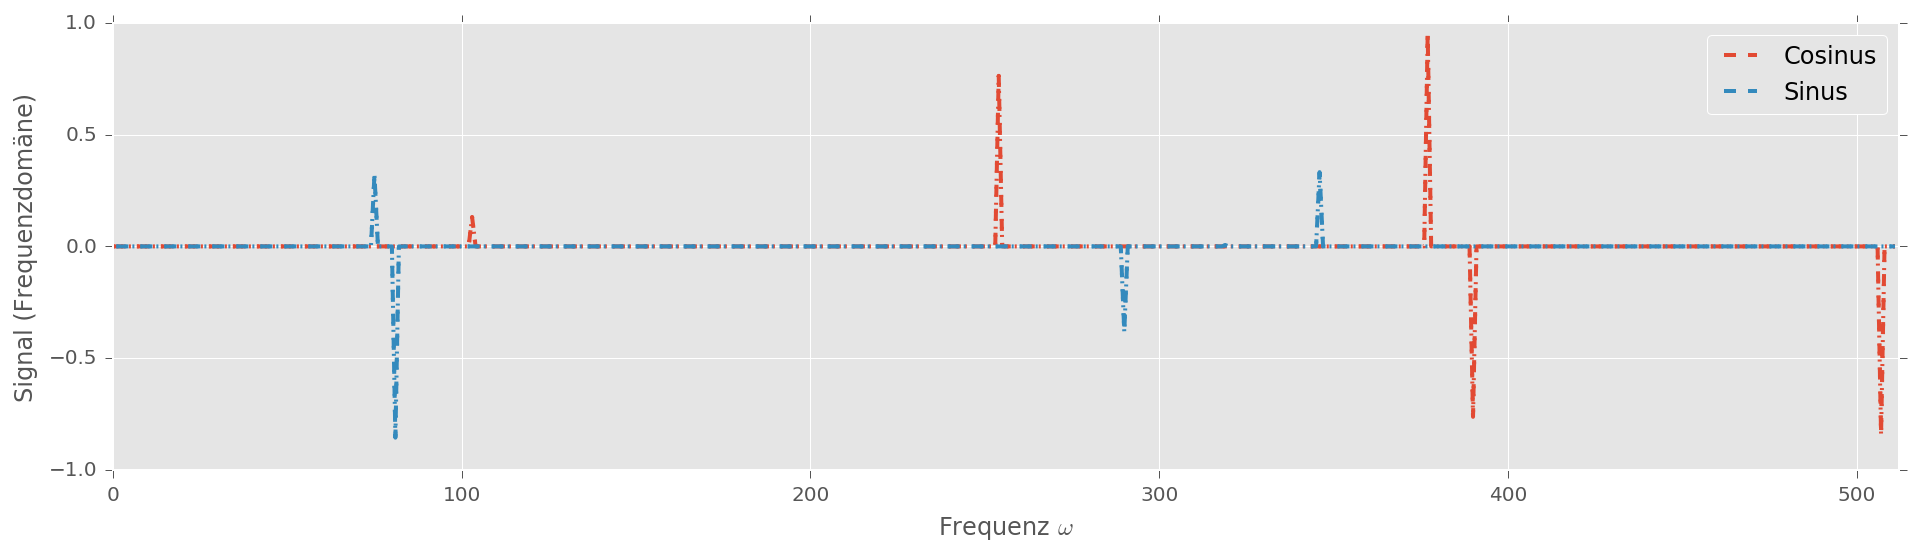

In [13]:
recovery = constraint_basis_pursuit(measurements[sample_points], signal[sample_points])

pl.figure(0, figsize=(16, 4))
l, *_ = pl.plot(omega, A[:N], label='Cosinus', ls='--')
pl.plot(omega, recovery[:N], ls=':', c=l.get_color())
l, *_ = pl.plot(omega[1:], A[N:], label='Sinus', ls='--')
pl.plot(omega[1:], recovery[N:], ls=':', c=l.get_color())

pl.xlim(0, N)
pl.xlabel(r"Frequenz $\omega$")
pl.ylabel(u"Signal (Frequenzdomäne)")
pl.legend()

In [14]:
nr_meas = range(5, 101, 5)
recoveries = [constraint_basis_pursuit(measurements[sample_points[:N]], signal[sample_points[:N]])
              for N in nr_meas]


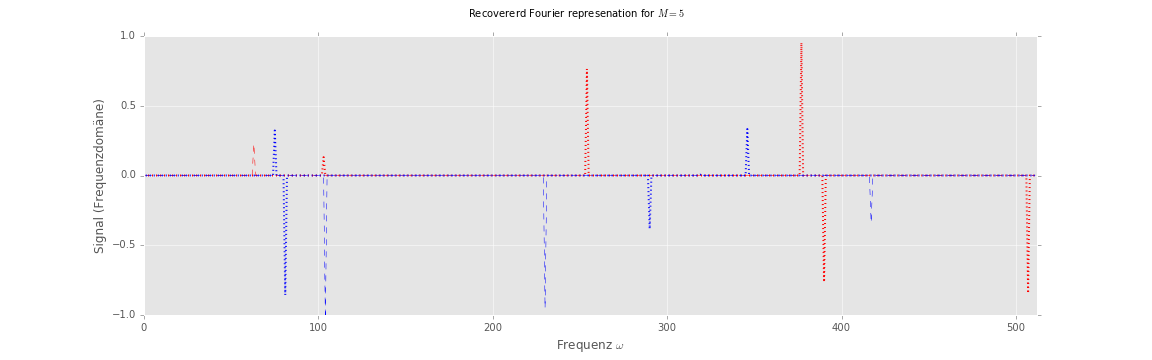
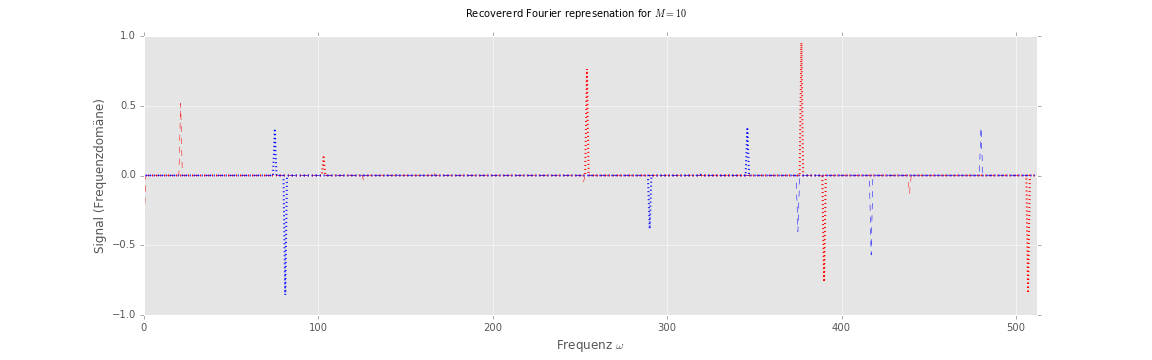
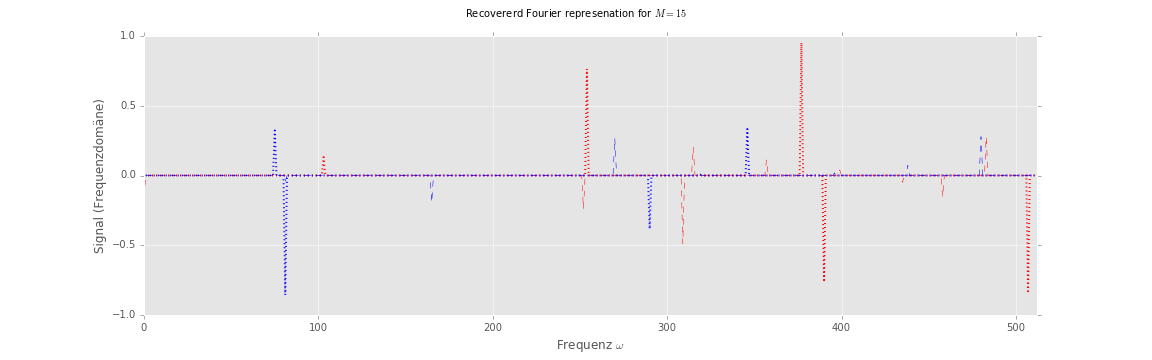
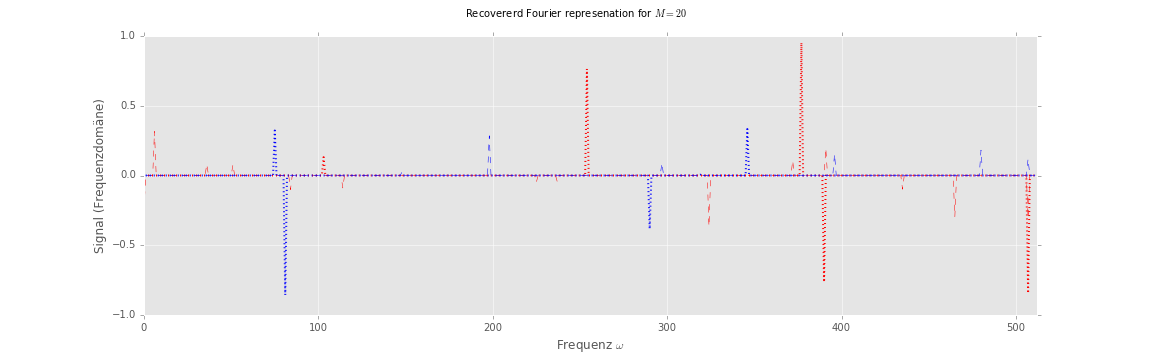
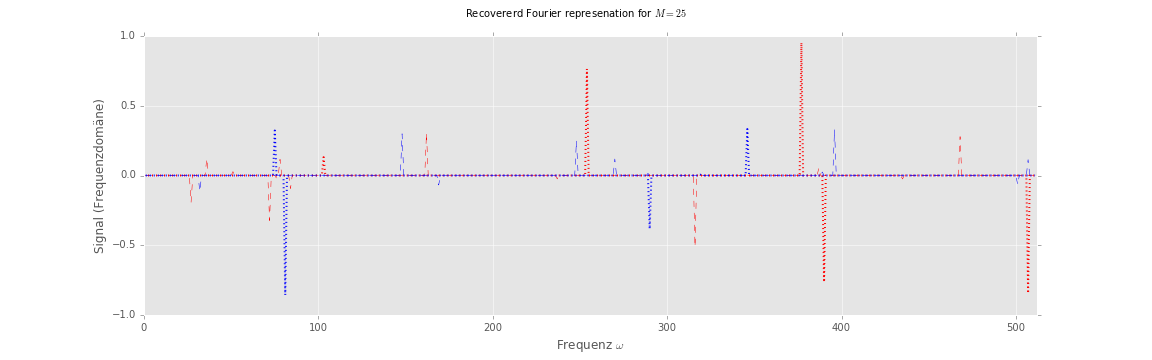
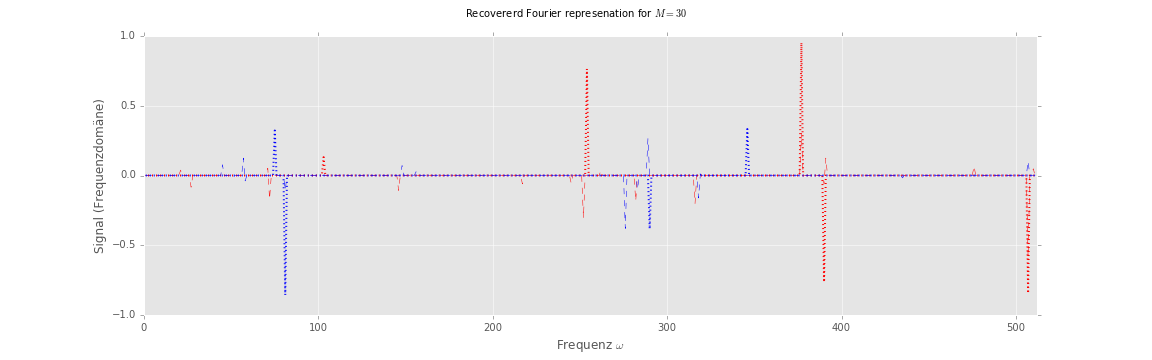
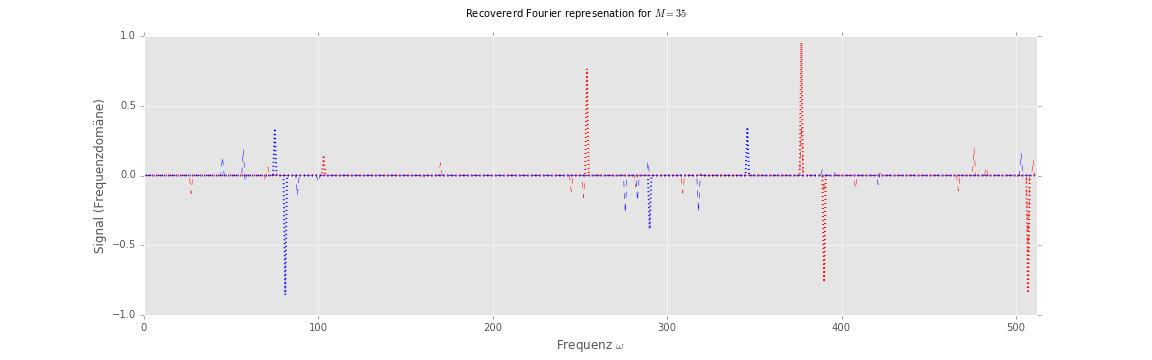
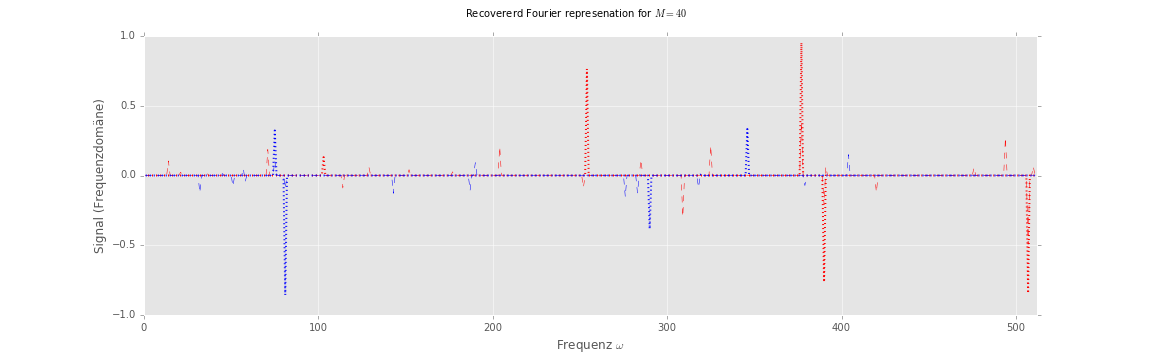
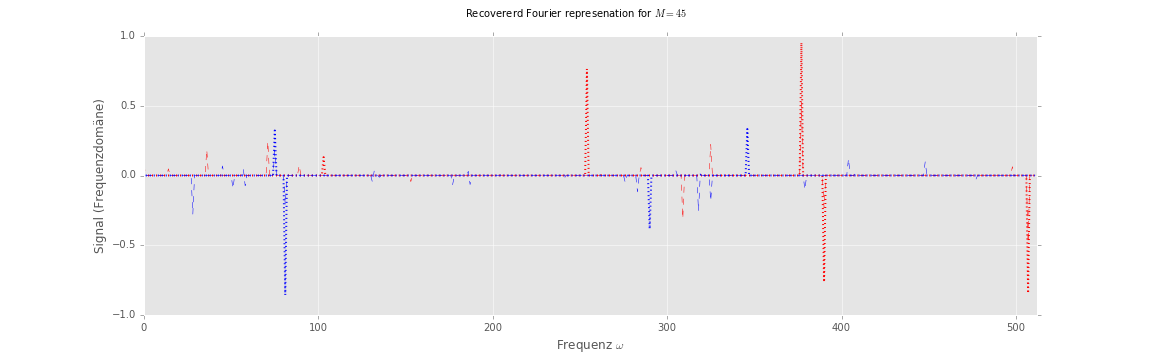
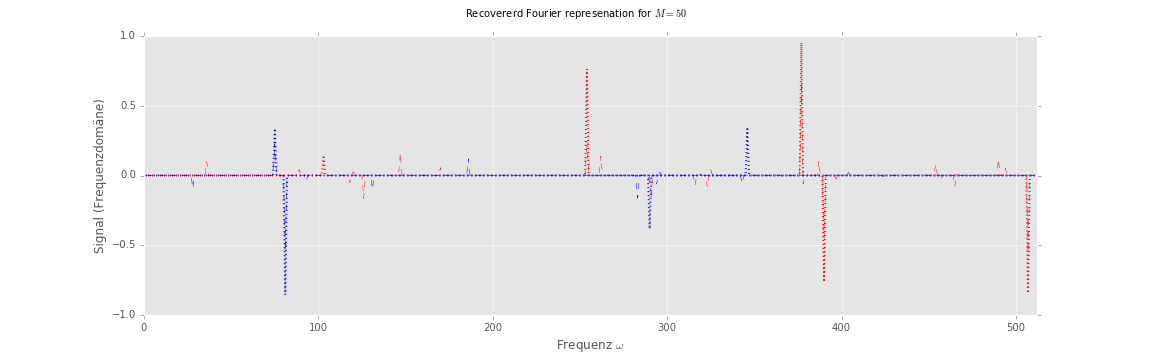
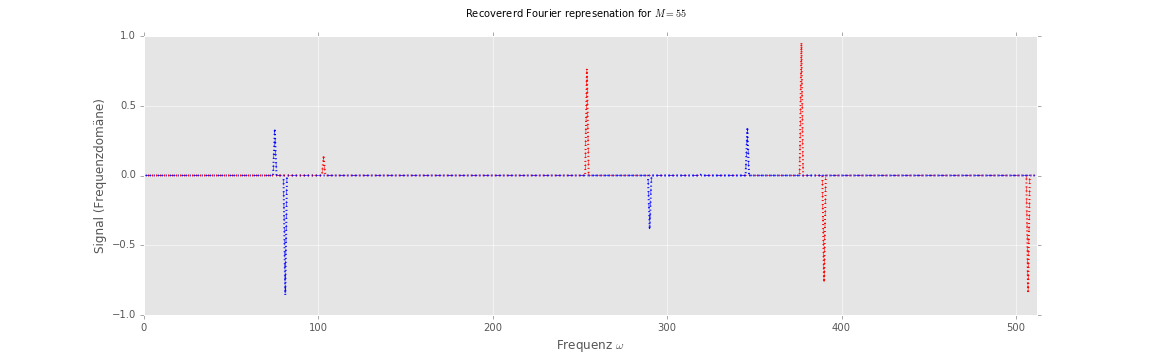
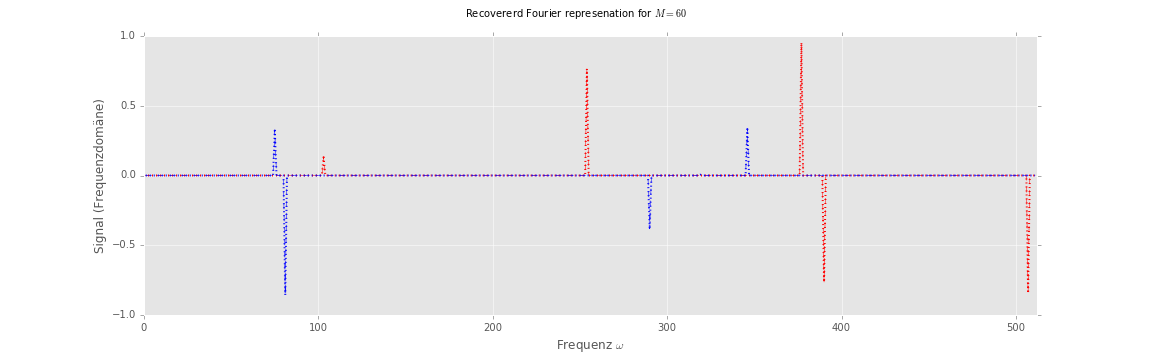
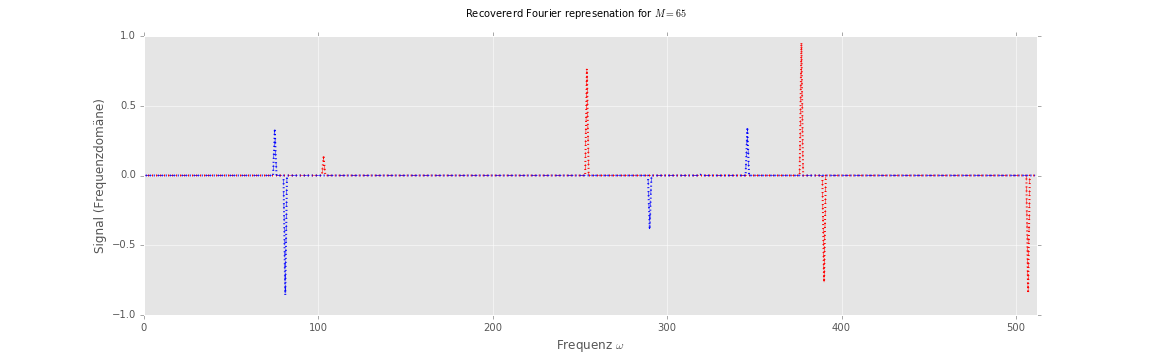
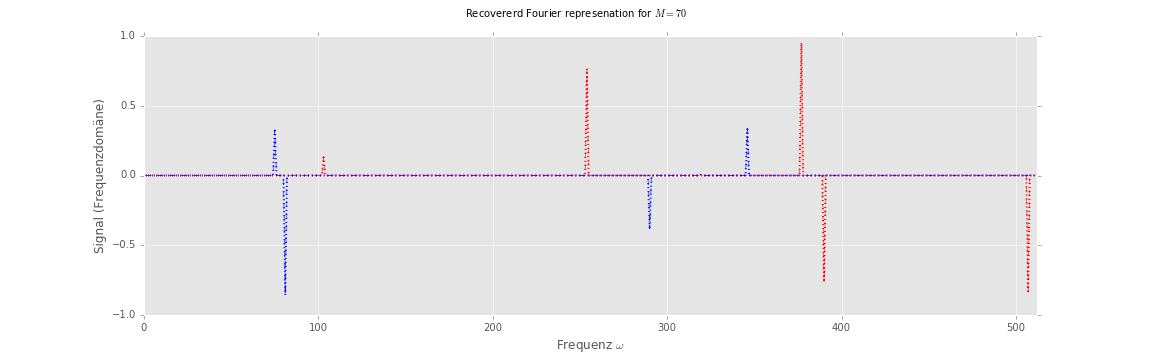
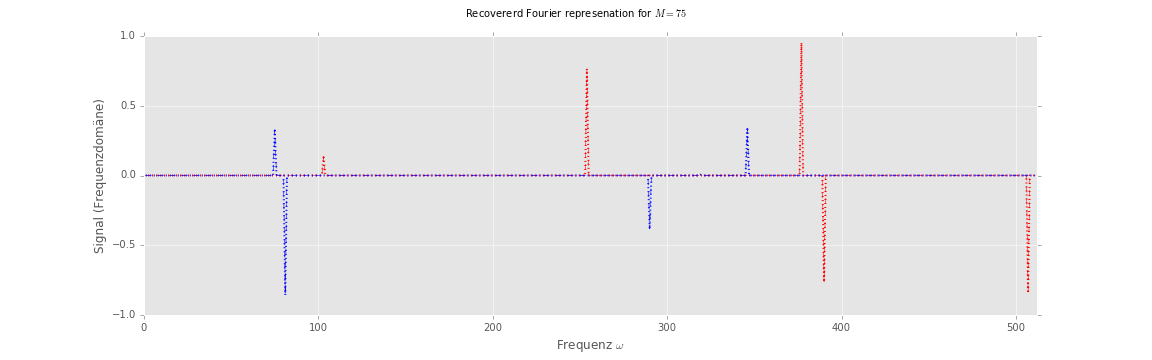
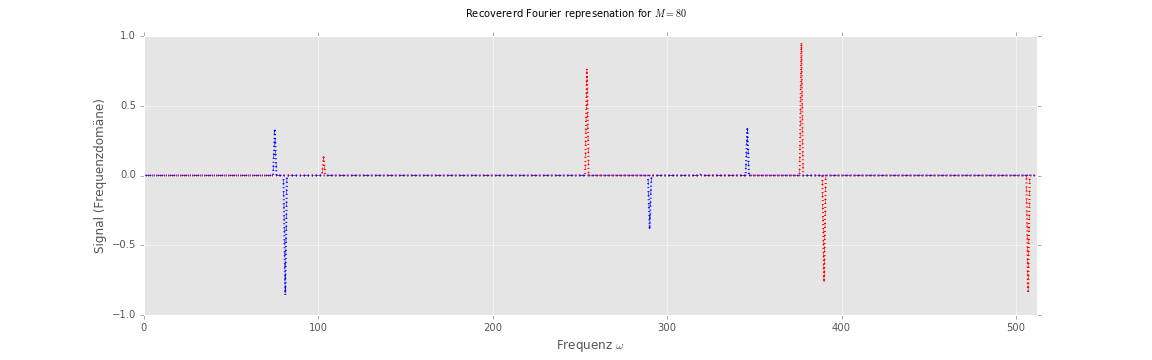
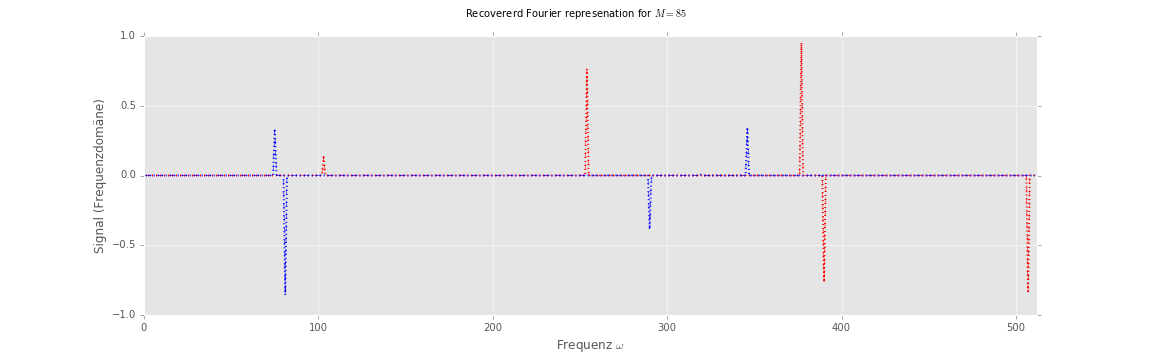
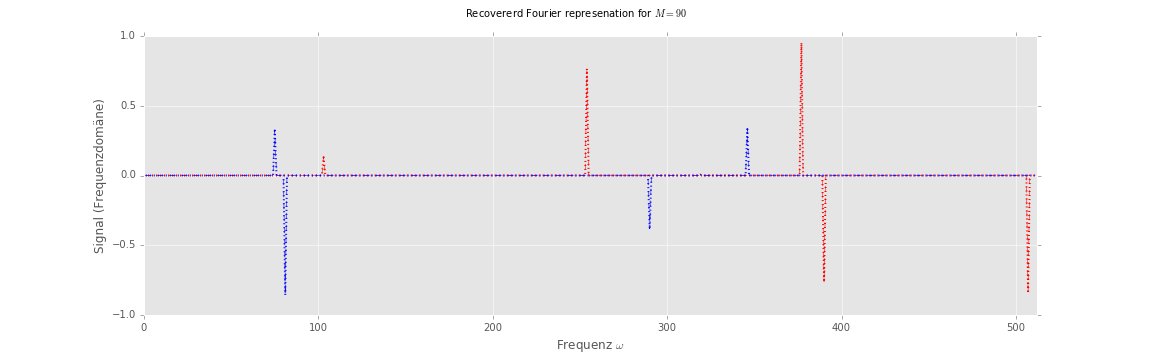
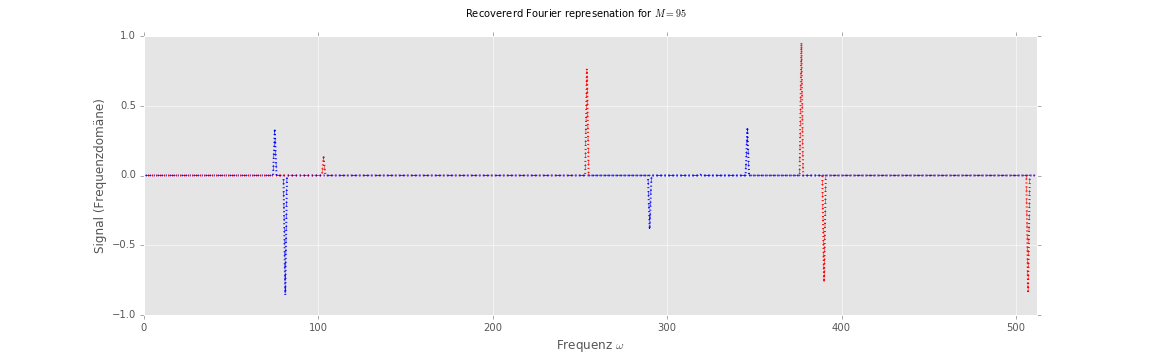
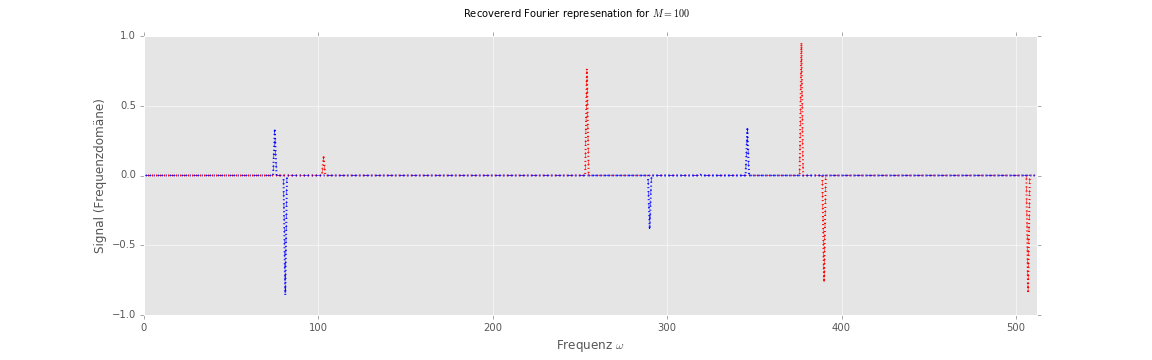

In [15]:
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

# create a simple animation
fig = pl.figure(0, figsize=(16, 5))
k = np.arange(N)
lines = []
lines.append(pl.plot([], ls='--', color='r', lw=.5)[0])
pl.plot(k, A[:N], ls=':', color='r')
lines.append(pl.plot([], ls='--', color='b', lw=.5)[0])
pl.plot(k[1:], A[N:], ls=':', color='b')

pl.xlim(0, N)
pl.xlabel(r"Frequenz $\omega$")
pl.ylabel(u"Signal (Frequenzdomäne)")

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    fig.suptitle(r"Recovererd Fourier represenation for $M={}$".format(nr_meas[i]))
    lines[0].set_data(omega, recoveries[i][:N])
    lines[1].set_data(omega[1:], recoveries[i][N:])
    return lines

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=len(recoveries), interval=300, blit=False)